**Get harp TTL data frame**

In [2]:
# Import main libraries and define data folder
import harp
import pandas as pd
from harp.model import Model, Register, Access
import os
from pathlib import Path
import matplotlib.pyplot as plt

import utils.harp_utils as hu

#==============================================================================
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'

# animal_ID = 'FNT107'
# session_ID = '2024-08-11T14-01-24'

# path behavioural data on ceph repo
input_dir = Path("W:/projects/FlexiVexi/raw_data")
output_dir = Path("C:/Users/megan/Documents/sjlab/flexible-navigation-task" +
              r"/data_analysis/intermediate_variables")

#==============================================================================

# Create reader for behavior.
bin_b_path = input_dir / animal_ID / session_ID / "Behavior.harp"
behavior_reader = harp.create_reader(bin_b_path)

# Specify mapping from sound index to reward port
soundIdx0 = 14
soundIdx1 = 10
soundOffIdx = 18

**Align dot times with experimental-data-csv**

In [4]:
# Import behavioral data as data frame
session_path = input_dir / animal_ID / session_ID
filepath = session_path / 'Experimental-data' / (session_ID + '_experimental-data.csv')
trials_df = pd.read_csv(filepath)

# Get dot onset and offset times given by TTL pulses

## First dot onset time from software clock (used as a common sense check for inconsistencies with number of TTL pulses on start up)
t0 = trials_df['DotOnsetTime'].iloc[0]

## Get dot times from TTL pulses
[dot_times_ttl, ttl_state_0] = hu.get_dot_times_from_ttl(behavior_reader, t0, return_TTL_state_at_startup=True)
print('TTL state upon start-up: ', ttl_state_0)

# Append dot onset and offset times given by TTL pulses to trials_df
trials_df = pd.concat([trials_df, dot_times_ttl],axis=1)
# rename 'DotOnsetTime' and 'DotOffsetTime' columns to 'DotOnsetTime_harp' and 'DotOffsetTime_harp'
trials_df.rename(columns = {
        'DotOnsetTime_ttl':'DotOnsetTime_harp', 
        'DotOffsetTime_ttl':'DotOffsetTime_harp'
        }, 
    inplace = True)

# Common sense check that the logic of aligning the TTL pulses is working as expected.
# Check dot onset and times from software clock TTL pulses are consistent, given by:
# - DotOnsetTime = dot onset time from software clock
# - DotOnsetTime_ttl = dot onset time from TTL pulses
# - DotOffsetTime = dot offset time from software clock
# - DotOffsetTime_ttl = dot offset time from TTL pulses

trials_df[['TrialStart', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp', 'DotOffsetTime_harp']]

TTL state upon start-up:  0


,TrialStart,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp,DotOffsetTime_harp
0,2.419933e+06,2.419933e+06,2.419959e+06,2.419933e+06,2.419959e+06
1,2.419963e+06,2.419963e+06,2.419968e+06,2.419963e+06,2.419968e+06
2,2.419971e+06,2.419971e+06,2.420007e+06,2.419971e+06,2.420007e+06
3,2.420013e+06,2.420013e+06,2.420024e+06,2.420013e+06,2.420024e+06
4,2.420029e+06,2.420029e+06,2.420036e+06,2.420029e+06,2.420036e+06
...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,2.423117e+06,2.423114e+06,2.423117e+06
264,2.423121e+06,2.423121e+06,2.423123e+06,2.423121e+06,2.423123e+06
265,2.423125e+06,2.423125e+06,2.423130e+06,2.423125e+06,2.423130e+06
266,2.423132e+06,2.423132e+06,2.423138e+06,2.423132e+06,2.423138e+06


**Get all poke events**

In [5]:
# Read the behavior harp stream, Digital Input states for the nosepoke timestamps and IDs. Drop DI3 <-- What's DI3??
all_pokes = behavior_reader.DigitalInputState.read()

all_pokes.drop(columns=['DI3','DIPort2'],inplace = True) # remove all nose pokes to dummy port
#all_pokes.reset_index(inplace=True)

# Show resulting data frame
all_pokes.head()

,DIPort0,DIPort1
Time,,
2.419931e+06,False,False
2.419953e+06,True,False
2.419954e+06,False,False
2.419954e+06,True,False
2.419954e+06,False,False


**Get all audio events**

In [6]:
# Load the sound card binary data (register 32) and show resulting dataframe
bin_sound_path = os.path.join(input_dir, animal_ID, session_ID, "SoundCard.harp","SoundCard_32.bin")

# the explicitly defined model will be deprecated or redundant in future
model = Model(device='Soundcard', whoAmI=1280,firmwareVersion='2.2',hardwareTargets='1.1',registers={'PlaySoundOrFrequency': Register(address=32, type="U16", access=Access.Event)})
sound_reader = harp.create_reader(model, keep_type=True)

# Read the harp sound card stream, for the timestamps and audio ID
all_sounds = hu.get_all_sounds(sound_reader, bin_sound_path)

# Show dataframe (maybe)
all_sounds.head(10)

all_sounds_test = all_sounds[all_sounds['PlaySoundOrFrequency'] != soundOffIdx]
all_sounds_test


,Time,PlaySoundOrFrequency,MessageType
3,2.419953e+06,14,EVENT
7,2.419963e+06,10,EVENT
11,2.419983e+06,14,EVENT
15,2.419994e+06,14,EVENT
19,2.419995e+06,14,EVENT
...,...,...,...
2139,2.423117e+06,14,EVENT
2143,2.423121e+06,14,EVENT
2147,2.423129e+06,10,EVENT
2151,2.423136e+06,10,EVENT


**Get trial start times in harp clock**

In [7]:
# check training stage specified in 'trials_df'
stage = trials_df['TrainingStage'].iloc[0]

# get trial start times for the specified stage
if stage == 4:
    dot_onset_times = trials_df['DotOnsetTime_harp']
    trial_start_times = hu.get_trial_start_times(4, dot_onset_times=dot_onset_times)
elif stage == 5:
    trial_start_times = hu.get_trial_start_times(5, bin_sound_path=bin_sound_path, sound_reader=sound_reader)

# Append trial start times to trials_df
trials_df = pd.concat([trials_df, trial_start_times.rename('TrialStart_harp')],axis=1)

trials_df[['TrialStart', 'TrialStart_harp', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp', 'DotOffsetTime_harp']]

,TrialStart,TrialStart_harp,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp,DotOffsetTime_harp
0,2.419933e+06,2.419933e+06,2.419933e+06,2.419959e+06,2.419933e+06,2.419959e+06
1,2.419963e+06,2.419963e+06,2.419963e+06,2.419968e+06,2.419963e+06,2.419968e+06
2,2.419971e+06,2.419971e+06,2.419971e+06,2.420007e+06,2.419971e+06,2.420007e+06
3,2.420013e+06,2.420013e+06,2.420013e+06,2.420024e+06,2.420013e+06,2.420024e+06
4,2.420029e+06,2.420029e+06,2.420029e+06,2.420036e+06,2.420029e+06,2.420036e+06
...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,2.423114e+06,2.423117e+06,2.423114e+06,2.423117e+06
264,2.423121e+06,2.423121e+06,2.423121e+06,2.423123e+06,2.423121e+06,2.423123e+06
265,2.423125e+06,2.423125e+06,2.423125e+06,2.423130e+06,2.423125e+06,2.423130e+06
266,2.423132e+06,2.423132e+06,2.423132e+06,2.423138e+06,2.423132e+06,2.423138e+06


**Align poke events with trials**

Get data frame with port choice ID and timestamp for each trial, where the port choice is taken as the first nose poke within the response window (between dot offset and trial end). If the trial is aborted, the port ID and timestamp are both taken as NaN.

In [8]:
# Get data frame with port choice ID and timestamp for each trial
port_choice_df = hu.get_port_choice(trials_df, behavior_reader)

# Append port choice to trials_df
trials_df = pd.concat([trials_df, port_choice_df],axis=1)

# Show port choice data frame
port_choice_df.head()

,ChoicePort,ChoiceTimestamp
0,0,2.419961e+06
1,1,2.419969e+06
2,1,2.420009e+06
3,0,2.420027e+06
4,0,2.420037e+06


**Align sound events to trials**

In [9]:
def parse_trial_sounds(trial_start_times, sound_reader, bin_sound_path, OFF_index=18):
    # Read the harp sound card stream, for the timestamps and audio ID
    all_sounds = hu.get_all_sounds(sound_reader, bin_sound_path)

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trial start times and extract data from harp stream
    for i, start_time in enumerate(trial_start_times):
        if i < len(trial_start_times) - 1:
            end_time = trial_start_times[i + 1]
        else:
            end_time = start_time + 100  # 100 seconds after the last trial start time

        # Extract events that occur within the time range of this trial
        trial_events = all_sounds[(all_sounds.Time >= start_time) & (all_sounds.Time <= end_time)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # Find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)
            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
        
    trial_sounds_df = pd.DataFrame({'AudioCueStart_harp': ON_S, 'AudioCueEnd_harp': OFF_S, 'AudioCueIdentity_harp': ID_S})  # Create dataframe from all nosepoke events

    return trial_sounds_df

# Get data frame with sound ID and timestamp for each trial
trial_sounds_df = parse_trial_sounds(trials_df['TrialStart_harp'], sound_reader, bin_sound_path)

# Append sound ID to trials_df
trials_df = pd.concat([trials_df, trial_sounds_df],axis=1)

# Show sound data frame
trial_sounds_df.head()

,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity_harp
0,[2419952.5272],[2419961.359232],[14]
1,[2419963.449888],[2419968.743232],[10]
2,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...","[14, 14, 14, 14, 14]"
3,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]","[14, 14]"
4,[2420034.889504],[2420037.260128],[10]


In [17]:
# Check trials_df AudioCueStart and ChoicePort is as expected
trials_df[
    [
        'TrialStart',
        'TrialStart_harp',
        'TrialCompletionCode',
        'ChoicePort',
        'ChoiceTimestamp',
        'AudioCueStart_harp',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
]

,TrialStart,TrialStart_harp,TrialCompletionCode,ChoicePort,ChoiceTimestamp,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity
0,2.419933e+06,2.419933e+06,RewardedNosepoke0,0,2.419961e+06,[2419952.5272],[2419961.359232],14
1,2.419963e+06,2.419963e+06,RewardedNosepoke1,1,2.419969e+06,[2419963.449888],[2419968.743232],10
2,2.419971e+06,2.419971e+06,IncorrectNosepoke1,1,2.420009e+06,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...",14
3,2.420013e+06,2.420013e+06,RewardedNosepoke0,0,2.420027e+06,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]",14
4,2.420029e+06,2.420029e+06,IncorrectNosepoke0,0,2.420037e+06,[2420034.889504],[2420037.260128],10
...,...,...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,RewardedNosepoke0,0,2.423119e+06,[2423116.823168],[2423119.257824],14
264,2.423121e+06,2.423121e+06,RewardedNosepoke0,0,2.423123e+06,[2423121.284512],[2423123.433824],14
265,2.423125e+06,2.423125e+06,RewardedNosepoke1,1,2.423130e+06,[2423129.004512],[2423129.852512],10
266,2.423132e+06,2.423132e+06,IncorrectNosepoke0,0,2.423138e+06,[2423136.225856],[2423138.4072],10


**Check consistency of harp clock timestamps with experimental-data.csv**

DotOnsetTime and TrialStart are distinct on stage 4.1 in experimental-data.csv:

<Axes: >

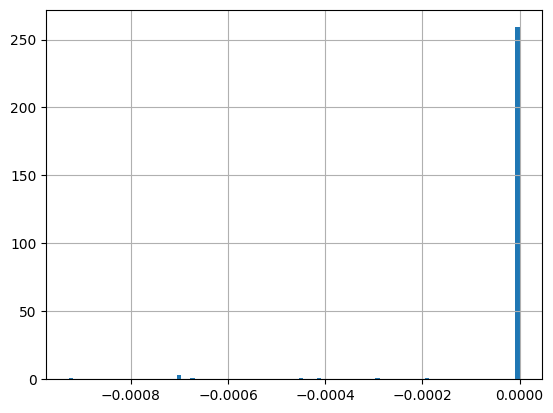

In [10]:
# take difference between TrialStart and DotOnsetTime_harp
test = trials_df['TrialStart'] - trials_df['DotOnsetTime']

# Get histogram of differences between DotOnsetTime_harp and DotOnsetTime
fig, ax = plt.subplots()
test.hist(bins=100, ax=ax)

Trial start time inferred from TTL pulses has some jitter relative to TrialStart (or DotOnset) in experimental-data.csv:

Text(0.5, 1.0, 'Histogram of differences between DotOnsetTime_harp and TrialStart')

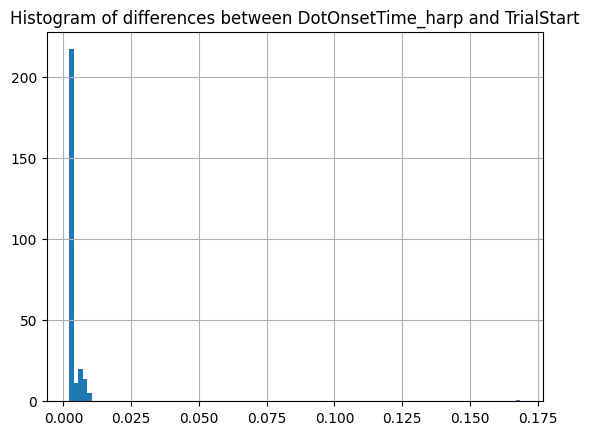

In [20]:
# take difference between TrialStart and DotOnsetTime_harp
trials_df['DotOnsetTime_harp_diff'] = trials_df['DotOnsetTime_harp'] - trials_df['TrialStart']

# Get histogram of differences between DotOnsetTime_harp and DotOnsetTime
fig, ax = plt.subplots()
trials_df['DotOnsetTime_harp_diff'].hist(bins=100, ax=ax)
ax.set_title('Histogram of differences between DotOnsetTime_harp and TrialStart')

Timestamp of nosepoke for port choice is identical in both experimental-data.csv and harp binary files:

<Axes: >

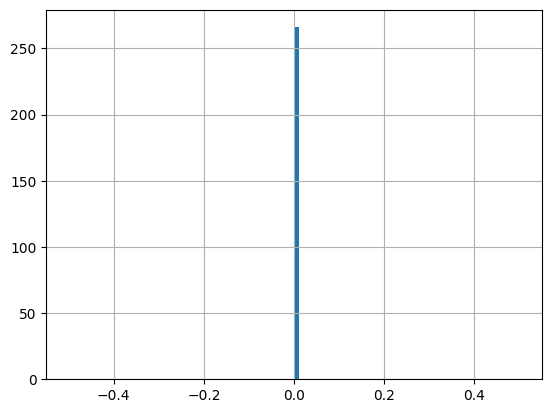

In [21]:
# take difference between TrialStart and DotOnsetTime_harp
trials_df['choiceTimestamp_diff'] = trials_df['ChoiceTimestamp'] - trials_df['NosepokeInTime']

# Get histogram of differences between DotOnsetTime_harp and DotOnsetTime
fig, ax = plt.subplots()
trials_df['choiceTimestamp_diff'].hist(bins=100, ax=ax)

Compare sound onset time in experimental-data.csv to sound onset in harp time:

In [22]:
# Check trials_df AudioCueStart and ChoicePort is as expected
trials_df[
    [
        'AudioCueStart',
        'AudioCueStart_harp',
        'AudioCueEnd',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
].head()

,AudioCueStart,AudioCueStart_harp,AudioCueEnd,AudioCueEnd_harp,AudioCueIdentity
0,2.419953e+06,[2419952.5272],2.419961e+06,[2419961.359232],14
1,2.419963e+06,[2419963.449888],2.419969e+06,[2419968.743232],10
2,2.420007e+06,"[2419982.98432, 2419994.225376, 2419995.209408...",2.420009e+06,"[2419983.109664, 2419995.16672, 2419995.24672,...",14
3,2.420023e+06,"[2420017.12944, 2420023.22544]",2.420018e+06,"[2420017.806752, 2420026.766784]",14
4,2.420035e+06,[2420034.889504],2.420037e+06,[2420037.260128],10


<Axes: >

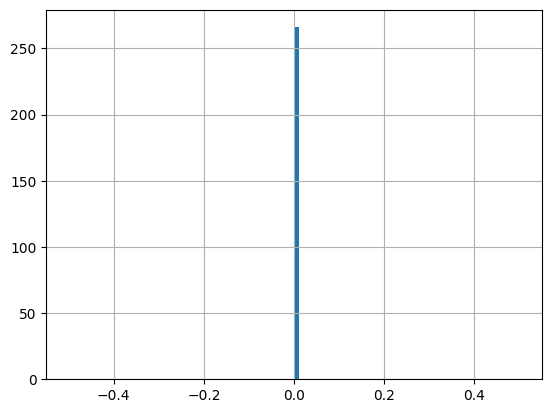

In [23]:
# Get difference between AudioCueStart and first value of AudioCueStart_harp
trials_df['AudioCueStart_diff'] = trials_df['AudioCueStart'] - trials_df['AudioCueStart_harp'].apply(lambda x: x[0])

# Get histogram of differences between AudioCueStart in harp binary file versus AudioCueStart in .csv
fig, ax = plt.subplots()
trials_df['choiceTimestamp_diff'].hist(bins=100, ax=ax)